In [51]:
%load_ext autoreload
%autoreload 2
import sys
extra_path = "/Users/iraklis/Public/iraklis7_linrg" # whatever individual directory it is
if extra_path not in sys.path:
    sys.path.append(extra_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


--- Logging error in Loguru Handler #1 ---
Record was: {'elapsed': datetime.timedelta(seconds=1272, microseconds=732001), 'exception': None, 'extra': {}, 'file': (name='config.py', path='/Users/iraklis/Public/iraklis7_linrg/iraklis7_linrg/config.py'), 'function': '<module>', 'level': (name='INFO', no=20, icon='ℹ️'), 'line': 18, 'message': 'PROJ_ROOT path is: /Users/iraklis/Public/iraklis7_linrg', 'module': 'config', 'name': 'iraklis7_linrg.config', 'process': (id=89567, name='MainProcess'), 'thread': (id=8601971776, name='MainThread'), 'time': datetime(2026, 1, 20, 21, 2, 46, 722968, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200), 'EET'))}
Traceback (most recent call last):
  File "/Users/iraklis/Public/iraklis7_linrg/lib/python3.14/site-packages/loguru/_handler.py", line 206, in emit
    self._sink.write(str_record)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "/Users/iraklis/Public/iraklis7_linrg/lib/python3.14/site-packages/loguru/_simple_sinks.py", line 123, in write
    self

In [ ]:
import numpy as np
from pathlib import Path
import iraklis7_linrg.config as config
import iraklis7_linrg.plots as plots
import iraklis7_linrg.features as features
import iraklis7_linrg.dataset as dataset

### Load the data

In [53]:
input_path: Path = config.RAW_DATA_DIR / config.DATASET
plot_path: Path = config.FIGURES_DIR / config.CLEANING_PLOT

data = config.read_data(input_path)
if data is None:
    raise ValueError("read_data failed - data is None")

### Data transformation

In [54]:
data_tr = dataset.transform_data(data, 300)
data_tr.head()   

,Κωδικός Συστήματος,Εμβαδόν,Όροφος,Σύνολο ορόφων,Ασανσέρ,Θέα,Έτος κατασκευής,Έτος ανακαίνισης,Τιμή,Αρχική Τιμή
0,18055522,130,1.0,4.0,1,1.0,1988.0,2022.0,245.0,NaN
1,17845458,104,2.0,NaN,1,1.0,1978.0,NaN,171.0,179.0
2,18396501,132,7.0,7.0,1,1.0,1976.0,2000.0,400.0,NaN
3,18652593,117,6.0,NaN,1,1.0,2024.0,NaN,370.0,NaN
4,18433163,105,5.0,7.0,1,1.0,1972.0,NaN,229.0,NaN


In [ ]:
output_path: Path = config.PROCESSED_DATA_DIR / config.DATASET_PROC
config.write_data(output_path,data_tr)

### Feature Engineering

In [ ]:
# Return true if floor is the last floor on the building
data_tr['Όροφος Ρετιρέ'] = data_tr.apply(lambda row: features.is_top_floor(row['Όροφος'], row['Σύνολο ορόφων']), axis=1) 
data_tr[['Όροφος Ρετιρέ', 'Όροφος', 'Σύνολο ορόφων']].head()

,Όροφος Ρετιρέ,Όροφος,Σύνολο ορόφων
0,0,1.0,4.0
1,0,2.0,NaN
2,1,7.0,7.0
3,0,6.0,NaN
4,0,5.0,7.0


In [ ]:
# Returns a label based on the age of the property
data_tr['Ηλικία'] = data_tr['Έτος κατασκευής'].apply(features.calc_age)
data_tr[['Ηλικία', 'Έτος κατασκευής']].head()

,Ηλικία,Έτος κατασκευής
0,0,1988.0
1,-1,1978.0
2,-1,1976.0
3,1,2024.0
4,-1,1972.0


In [ ]:
# Returns a label based on the condition of the property
data_tr['Κατάσταση'] = data_tr.apply(lambda row: features.get_condition(row['Έτος κατασκευής'], row['Έτος ανακαίνισης']), axis=1)
data_tr[['Κατάσταση', 'Έτος κατασκευής', 'Έτος ανακαίνισης']].head()

,Κατάσταση,Έτος κατασκευής,Έτος ανακαίνισης
0,1,1988.0,2022.0
1,-1,1978.0,NaN
2,-1,1976.0,2000.0
3,1,2024.0,NaN
4,-1,1972.0,NaN


In [ ]:
# Return true if elevator exists and floor is third or higher
data_tr['Ασανσέρ από 3ο'] = data_tr.apply(lambda row: features.elevator_from_third(row['Όροφος'], row['Ασανσέρ']), axis=1) 
data_tr[['Ασανσέρ από 3ο', 'Όροφος', 'Ασανσέρ']].head()

,Ασανσέρ από 3ο,Όροφος,Ασανσέρ
0,0,1.0,1
1,0,2.0,1
2,1,7.0,1
3,1,6.0,1
4,1,5.0,1


### Normalize the data

In [ ]:
features = data_tr.drop(['Τιμή', 'Αρχική Τιμή'], axis=1)
features_norm = features.normalize_data(features)
labels = data_tr['Τιμή']

print(features_norm.head())
print (labels.head())

#print(f"Peak to Peak range by column in Raw        X:{np.ptp(features,axis=0)}")   
print(f"Peak to Peak range by column in Normalized dataset\n{np.ptp(features_norm,axis=0)}")

   Κωδικός Συστήματος   Εμβαδόν    Όροφος  Σύνολο ορόφων   Ασανσέρ       Θέα  \
0           -0.199786  0.479710 -1.321908      -0.642455  0.325222  0.607493   
1           -0.451020 -0.782906 -0.846847            NaN  0.325222  0.607493   
2            0.208021  0.576834  1.528456       1.047290  0.325222  0.607493   
3            0.514304 -0.151598  1.053395            NaN  0.325222  0.607493   
4            0.251868 -0.734344  0.578335       1.047290  0.325222  0.607493   

   Έτος κατασκευής  Έτος ανακαίνισης  Όροφος Ρετιρέ    Ηλικία  Κατάσταση  \
0         0.238054          0.399042      -0.402015  0.718692   1.247554   
1        -0.224027               NaN      -0.402015 -0.636219  -0.831703   
2        -0.316443         -1.581569       2.487469 -0.636219  -0.831703   
3         1.901545               NaN      -0.402015  2.073604   1.247554   
4        -0.501275               NaN      -0.402015 -0.636219  -0.831703   

   Ασανσέρ από 3ο  
0       -1.343457  
1       -1.343457  
2 

### Save normalized dataset, features and labels

In [ ]:
features_path: Path = config.PROCESSED_DATA_DIR / config.DATASET_PROC_FEATURES
labels_path: Path = config.PROCESSED_DATA_DIR / config.DATASET_PROC_LABELS
config.write_data(features_path,features_norm)
config.write_data(labels_path,labels)   

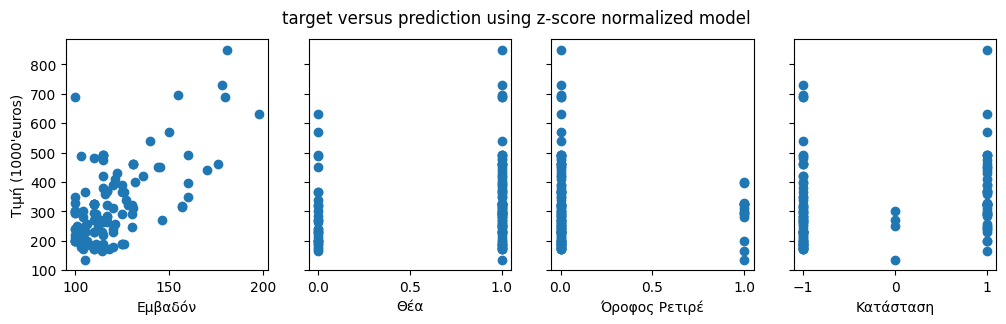

In [ ]:
features_sel = features[['Εμβαδόν', 'Θέα', 'Όροφος Ρετιρέ', 'Κατάσταση', 'Ασανσέρ από 3ο']]
plots.gen(list(features_sel), features_sel.to_numpy(), labels, None, None, None, plot_path, True)